In [1]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import keras
from keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedShuffleSplit, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from livelossplot import PlotLossesKeras
from IPython.display import clear_output
import os,pickle,sys

sys.path.insert(0, './code/')
"""
    https://arxiv.org/abs/2003.00598
"""
from Models import BiN_TABL

clear_output(wait=True)

In [2]:
PATH = "H:/_rl 2023-07-04/bData/"

#### 10days -> train/ 5days -> test
trainLen = 0
testLen = 0
X_train, Y_train=None, None
X_test, Y_test =None, None
fnames = [x[-1] for x in os.walk(PATH)][0]
fnames = sorted(fnames, key=len)

data = None
for fname in fnames:    
    if data is None:
        data = pickle.load(open(f"{PATH}{fname}", "rb"))
    else:
        data = np.vstack((data, pickle.load(open(f"{PATH}{fname}", "rb")) ))
    #print(fname)
data = data[~np.isinf(data).any(axis=1) | (data[:,-1] == 0)] # remove row that contains inf value
print(data.shape)

(159950, 12323)


In [3]:
L_LIST = [1,3,5,7,9,11,13,15,17,19,20,30,60,90,120,180,210,240,270,300]
X = data[:,:-len(L_LIST) - 3]
Y= data[:,-len(L_LIST) - 3:]

adf = pd.read_parquet("H:/_rl 2023-07-04/all.parquet")
df = pd.DataFrame({f'c{i}' : Y[:,i] for i in range(len(L_LIST) + 3)})
COLS_DIC = { c : f'pred_{l}' for c,l in zip(df.columns[:-3], L_LIST)}
COLS_DIC.update({
    df.columns[-1] : 'idx',
    df.columns[-2] : 'buyP',
    df.columns[-3] : '정규화_돌파물량'
})
df.rename(columns=COLS_DIC, inplace=True)

_c_ = .998 # 수수료 0.2%
for l in L_LIST:
    df[f'ret{l}'] = df[f'pred_{l}'] / df['buyP'] * _c_
df = pd.merge(df, adf, on='idx', how='inner')

In [8]:
# labeling
label = [19,20,30]
label_num = 0.9999
df['y'] = df[[f'ret{i}' for i in  label]].mean(axis=1) > label_num

In [5]:
W = 300
D = 41

idx = df.index.values 
X = X[idx, :]
X = X[:, D * (300 - W):]
print(X.shape, Y.shape)

(155726, 12300) (159950, 23)


In [9]:
Y = df['y'].values
print(np.mean(df['y']))

0.1988364178107702


In [12]:
numLabels = len( np.unique(Y) )
template = [
    [D,W ],
    [82, W ],
    [164, W],
    [numLabels,1]  
]
#### TABL configuration
projection_regularizer = None #keras.regularizers.l2(0.001)
projection_constraint = keras.constraints.max_norm(3.0,axis=0)
attention_regularizer = None #keras.regularizers.l2(0.0001)
attention_constraint = keras.constraints.max_norm(3.0, axis=1)

gamma1_regularizer = None
gamma1_constraint = keras.constraints.max_norm(3.0,axis=0)
gamma2_regularizer = None
gamma2_constraint= keras.constraints.max_norm(3.0,axis=0)

dropout = 0.1


model = BiN_TABL(
    template, 
    dropout, 
    projection_regularizer, 
    projection_constraint,
    attention_regularizer, 
    attention_constraint,
    gamma1_regularizer,
    gamma1_constraint,
    gamma2_regularizer,
    gamma2_constraint
)

# create class weight for class imbalance
class_weight = {
    0 : 1e6/810.0,
    1 : 1e6/190.0,
}
num_epoch = 500
stop_epoch_num = 20
batch_size = 128

es = EarlyStopping(
    monitor='val_acc',
    mode='auto', 
    patience = stop_epoch_num, 
    verbose=1, 
    baseline=None
)

unique, counts = np.unique(Y, return_counts = True)
print(model.summary())
print('TOTAL : {0}'.format(Y.shape[0]))
for a, b in zip(unique, counts):
    print("Class {0:d} : {1:.2f}%".format(int(a), b / Y.shape[0] * 100))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 41, 300)]         0         
_________________________________________________________________
bi_n_2 (BiN)                 (None, 41, 300)           684       
_________________________________________________________________
bl_4 (BL)                    (None, 82, 300)           117962    
_________________________________________________________________
activation_6 (Activation)    (None, 82, 300)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 82, 300)           0         
_________________________________________________________________
bl_5 (BL)                    (None, 164, 300)          152648    
_________________________________________________________________
activation_7 (Activation)    (None, 164, 300)          0   

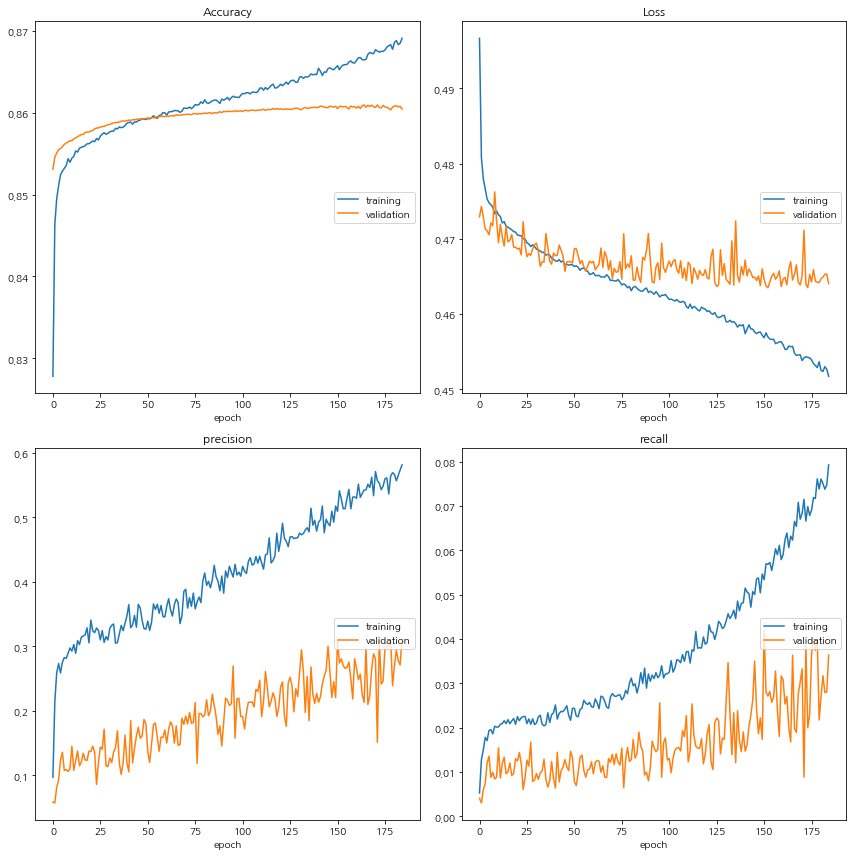

Accuracy
	training         	 (min:    0.828, max:    0.869, cur:    0.869)
	validation       	 (min:    0.853, max:    0.861, cur:    0.860)
Loss
	training         	 (min:    0.452, max:    0.497, cur:    0.452)
	validation       	 (min:    0.463, max:    0.476, cur:    0.464)
precision
	training         	 (min:    0.097, max:    0.581, cur:    0.581)
	validation       	 (min:    0.057, max:    0.312, cur:    0.311)
recall
	training         	 (min:    0.005, max:    0.079, cur:    0.079)
	validation       	 (min:    0.003, max:    0.042, cur:    0.036)
782/782 [==============================] - 31s 40ms/step - loss: 0.4517 - acc: 0.8691 - precision: 0.5811 - recall: 0.0793 - val_loss: 0.4640 - val_acc: 0.8604 - val_precision: 0.3113 - val_recall: 0.0364
Epoch 00185: early stopping


In [13]:
import matplotlib.pyplot as plt

class NonePrep:
    pass

T_LEN = df[df['date'] < "2023-05-00"].shape[0] # 999998
X_train, Y_train = X[:T_LEN,:], Y[:T_LEN]
X_valid, Y_valid = X[T_LEN:,:], Y[T_LEN:]
scaler = NonePrep()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_train = X_train.reshape(-1, D, W)
X_valid = X_valid.reshape(-1, D, W)

Y_train = keras.utils.to_categorical(Y_train)
Y_valid = keras.utils.to_categorical(Y_valid)

history = model.fit(
    X_train, Y_train, epochs=num_epoch, batch_size=batch_size, 
    #class_weight = class_weight,
    verbose=1, 
    validation_data=(X_valid, Y_valid), 
    callbacks = [es,PlotLossesKeras()]
)

#model.save(f'./data/Bin TABL s-{scaler.__class__.__name__} n-{numLabels} w-{W} b-{batch_size} t-{T_LEN} l-{len(template)} c-{label_num-1000} ll-{" ".join([str(i) for i in label])}.h5')

In [14]:
pred_v = model.predict(X_valid)
rdf = df.iloc[T_LEN:]
for i in range(numLabels):
    rdf[f'p{i}'] = pred_v[:,i]

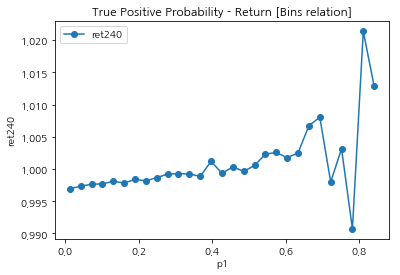

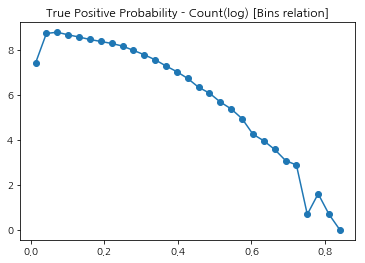

In [19]:
def BinGroupPlot(df, col=None,pcol=None, binNum=20):
    """
        df   : dataframe
        col  : bin column
        pcol : return column
    """
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    bins = np.linspace(df[col].min(), df[col].max(), binNum)
    xx   = df.groupby(np.digitize(df[col], bins), as_index=False).mean()
    xxx  = df.groupby(np.digitize(df[col], bins), as_index=False).count()
    
    plt.title("True Positive Probability - Return [Bins relation]")
    plt.plot([ bins[i] for i in xx.index], (xx[pcol]), label=f'{pcol}', marker='o')
    plt.legend()
    plt.xlabel(col)
    plt.ylabel(pcol)
    plt.show()

    plt.title("True Positive Probability - Count(log) [Bins relation]")
    plt.plot([ bins[i] for i in xxx.index], np.log(xxx[pcol]), label=f'{pcol}', marker='o')
    plt.show()
 
BinGroupPlot(rdf, col='p1',pcol='ret240',binNum=30)

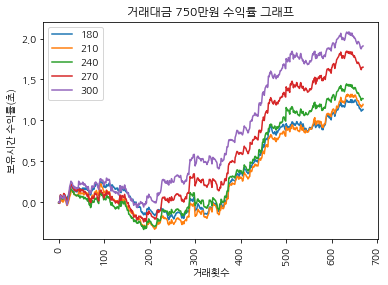

총 거래 횟수              670
거래 비율                 1.31%
손익비                    1.55%
승률                      47.91%
Trading Performance Index 1.22


In [32]:
prob = .5
r = rdf[ (rdf['p1'] > prob)]
for i in [180,210,240,270,300]:
    plt.plot(
        range(r.shape[0]), 
        np.log( r[f'ret{i}'].cumprod() ), 
        label=str(i) 
    )
plt.xticks(rotation=90)
plt.title('거래대금 750만원 수익률 그래프')
plt.xlabel('거래횟수')
plt.ylabel('보유시간 수익률(초)')
plt.legend()
plt.show()
    
    
winRate = np.mean( r[f'ret{i}'].values >= 1 )
profit = np.mean( r[r[f'ret{i}'] >= 1][f'ret{i}'] )
loss = np.mean( r[r[f'ret{i}'] < 1][f'ret{i}'] )

print('총 거래 횟수              {0}'.format(r.shape[0]))
print('거래 비율                 {0:.2f}%'.format(r.shape[0] / rdf.shape[0]*100))
print('손익비                    {0:.2f}%'.format( ((profit -1) / (1 - loss ))))
print('승률                      {0:.2f}%'.format(winRate*100))
print('Trading Performance Index {0:.2f}'.format( winRate * ((profit -1) / (1 - loss ) + 1)))